In [1]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet-without-dense-same-size]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = True      # Set to True if you want to see the loss function per epoch in real time

In [2]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

/home/mjenrungrot/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='[{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [4]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-03-06 19:24:40,014 - root - DEBUG - Keras backend is tensorflow.
2018-03-06 19:24:40,015 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 76, 121)`.

In [5]:
logger.debug("Load Paired-annotation data")
data = data_dict()
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))
ref_query_pairs = data['taylorswift']

songPairs = []
totalPairs = 0 
for ref, query in ref_query_pairs:
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair)
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-03-06 19:24:40,046 - root - DEBUG - Load Paired-annotation data
2018-03-06 19:24:40,048 - root - DEBUG - 	 data.type = <class 'dict'>
2018-03-06 19:24:40,049 - root - DEBUG - 	 data = {'taylorswift': <generator object get_ref_query_pairs at 0x7fca0599d5c8>}


/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.d

2018-03-06 19:24:59,990 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 76, 121)
2018-03-06 19:24:59,992 - root - DEBUG - Number of samples for the current song: 272
2018-03-06 19:25:18,919 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 76, 121)
2018-03-06 19:25:18,921 - root - DEBUG - Number of samples for the current song: 264
2018-03-06 19:25:26,115 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-06 19:25:26,116 - root - DEBUG - Number of samples for the current song: 100
2018-03-06 19:25:33,291 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-06 19:25:33,292 - root - DEBUG - Number of samples for the current song: 100
2018-03-06 19:25:49,170 - root - DEBUG - Song 5: Finish current pairs with shape = (221, 2, 76, 121)
2018-03-06 19:25:49,171 - root - DEBUG - Number of samples for the current song: 221
2018-03-06 19:26:07,348 - root - DEBUG - Song 6: Finish current pairs 

In [6]:
p_train = .4
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-03-06 19:26:38,209 - root - DEBUG - Finish loading paired-annotation data
2018-03-06 19:26:38,211 - root - DEBUG - => There are 4 songs for training [45.04 percent]
2018-03-06 19:26:38,212 - root - DEBUG - => There are 4 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [7]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [8]:
X1, X2, S, W, groundTruth = generate_training_data(data_train)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val)

2018-03-06 19:26:38,492 - root - DEBUG - X1 shape: (1736, 1, 76, 121)
2018-03-06 19:26:38,493 - root - DEBUG - X2 shape: (1736, 1, 76, 121)
2018-03-06 19:26:38,494 - root - DEBUG - S shape: (1736, 1)
2018-03-06 19:26:38,495 - root - DEBUG - W shape: (1736, 1)
2018-03-06 19:26:38,496 - root - DEBUG - There are 736 out of 1736 pairs that are similar [42.40 percent]
2018-03-06 19:26:38,675 - root - DEBUG - X1 shape: (1898, 1, 76, 121)
2018-03-06 19:26:38,676 - root - DEBUG - X2 shape: (1898, 1, 76, 121)
2018-03-06 19:26:38,677 - root - DEBUG - S shape: (1898, 1)
2018-03-06 19:26:38,677 - root - DEBUG - W shape: (1898, 1)
2018-03-06 19:26:38,678 - root - DEBUG - There are 898 out of 1898 pairs that are similar [47.31 percent]


In [9]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [10]:
width = 76
height = 121
n_channel = 1

In [11]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [12]:
model_path = '/data1/mint/public/taylorswift_out/model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-03-06 19:26:39,040 - root - DEBUG - Load model from /data1/mint/public/taylorswift_out/model.mat


In [13]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, refQ.shape, delta=delta, compute_delta=True)
logger.debug("Construct base model")

2018-03-06 19:26:39,616 - root - DEBUG - Construct base model


2018-03-06 19:26:39,772 - root - DEBUG - Save base_model architecture to base_model.png


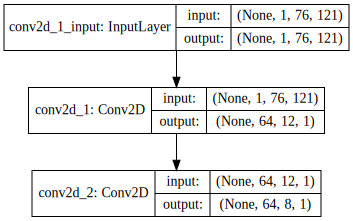

In [14]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [15]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [16]:
beta         = 1            # Initial beta value
numberOfBits = None
alpha        = 0.01         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-03-06 19:26:39,954 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = None, alpha = 0.01


In [17]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [18]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [19]:
activation_layer = Activation(custom_activation)
encoded_a = activation_layer(flatten_a)
encoded_b = activation_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [20]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-03-06 19:26:40,015 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [21]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [22]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-5")
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=zero_loss)

2018-03-06 19:26:40,042 - root - DEBUG - Use Adam optimizer with lr = 1e-5


__Visualize model architecture__

2018-03-06 19:26:40,375 - root - DEBUG - Save model architecture to model.png


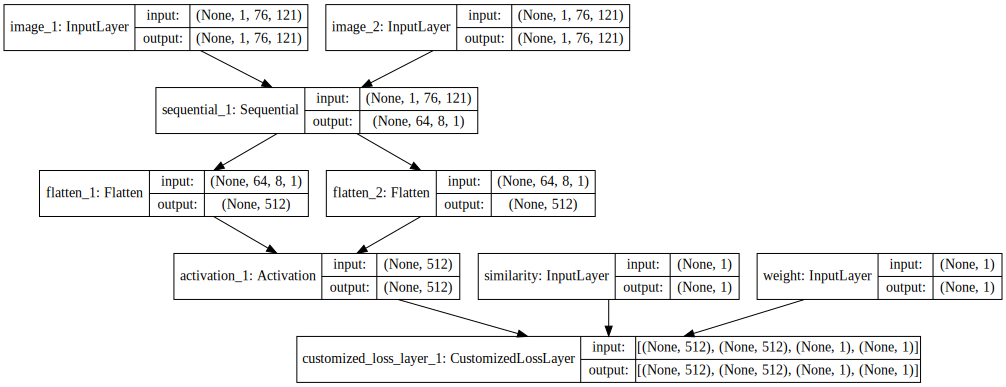

In [23]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [24]:
representation_model = Model(image_a, flatten_a)

In [25]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []
    bins = np.linspace(0, 400, 100)

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    plt.ylim((0, 135))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

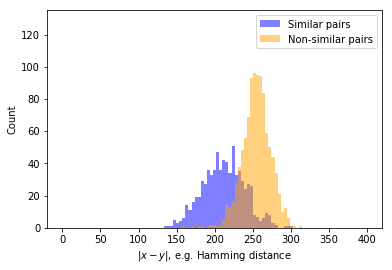

In [26]:
visualize(X1, X2, groundTruth, representation_model)

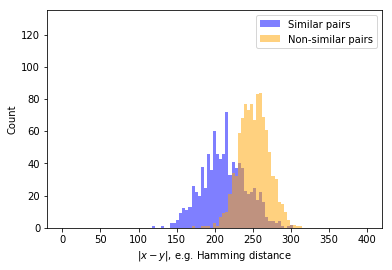

In [27]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [28]:
def visualizeFilters():
    nFilters = base_model.layers[0].get_weights()[0].shape[-1]
    plt.figure(figsize=(8,20))
    plt.tight_layout(pad=0, w_pad=0, h_pad=-10)
    for i in range(nFilters):
        filt = base_model.layers[0].get_weights()[0][:,:,0,i]
        plt.subplot(7, 10, i+1)
        plt.imshow(filt.T, cmap='jet')
        plt.xticks([])
        plt.yticks([])
    plt.show()

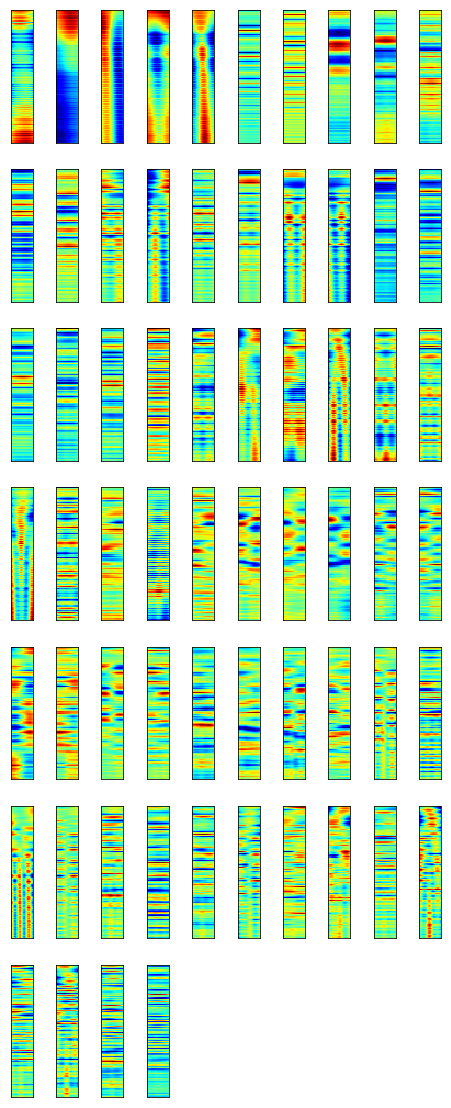

In [29]:
visualizeFilters()

## Train a model

In [30]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-06 19:26:45,521 - root - DEBUG - Ready to train the model
2018-03-06 19:26:45,523 - root - DEBUG - X1 shape: (1736, 1, 76, 121)
2018-03-06 19:26:45,524 - root - DEBUG - X2 shape: (1736, 1, 76, 121)
2018-03-06 19:26:45,525 - root - DEBUG - S shape: (1736, 1)
2018-03-06 19:26:45,526 - root - DEBUG - W shape: (1736, 1)


In [31]:
number_of_iterations = 5
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta_factor = 5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 50
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-06 19:26:45,532 - root - DEBUG - [Training] number_of_iterations = 5
2018-03-06 19:26:45,533 - root - DEBUG - [Training] beta_factor = 5
2018-03-06 19:26:45,535 - root - DEBUG - [Training] number_of_epochs = 50


In [32]:
train_losses = []
test_losses = []

2018-03-06 19:26:45,560 - root - DEBUG - Iteration 1 (current beta = 1)
Epoch 1/50
1736/1736 [==============================] - 1s 301us/step - loss: 35.6071
Epoch 2/50
1736/1736 [==============================] - 1s 290us/step - loss: 35.3137
Epoch 3/50
1736/1736 [==============================] - 0s 275us/step - loss: 35.1098
Epoch 4/50
1736/1736 [==============================] - 0s 268us/step - loss: 34.9037
Epoch 5/50
1736/1736 [==============================] - 0s 267us/step - loss: 34.7058
Epoch 6/50
1736/1736 [==============================] - 0s 255us/step - loss: 34.4678
Epoch 7/50
1736/1736 [==============================] - 0s 256us/step - loss: 34.2665
Epoch 8/50
1736/1736 [==============================] - 0s 278us/step - loss: 34.0368
Epoch 9/50
1736/1736 [==============================] - 0s 271us/step - loss: 33.8664
Epoch 10/50
1736/1736 [==============================] - 0s 251us/step - loss: 33.6293
Epoch 11/50
1736/1736 [==============================] - 0s 254us/s

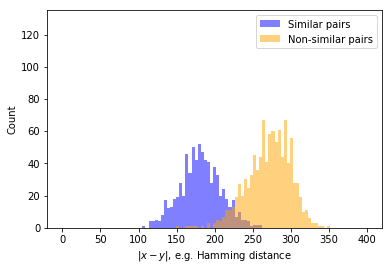

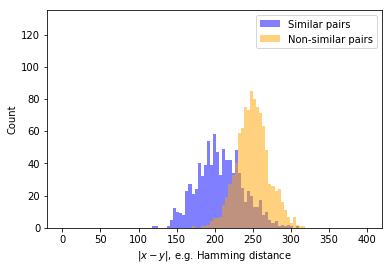

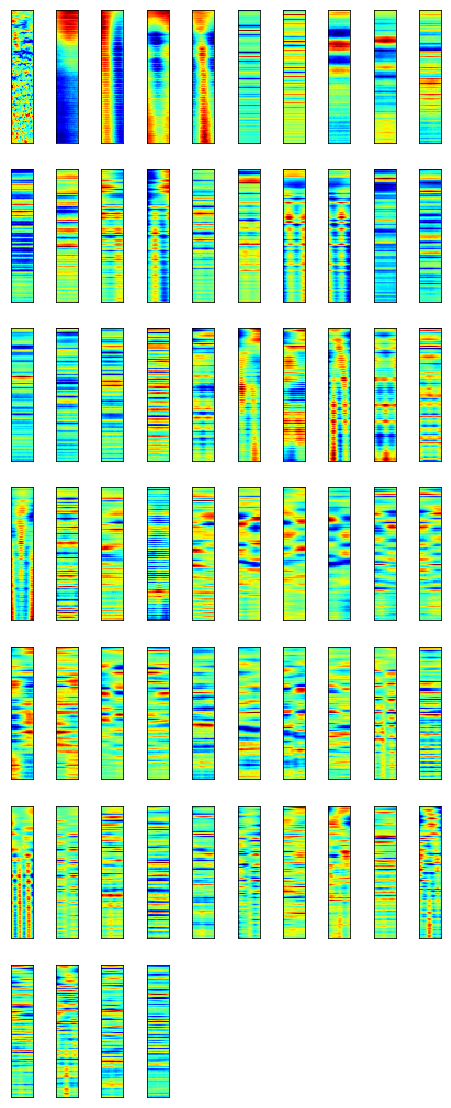

1898/1898 [==============================] - 0s 207us/step
2018-03-06 19:27:15,441 - root - DEBUG - [Iteration = 1] Training Loss = 27.201385027801937, Testing Loss = 36.41744769812886
2018-03-06 19:27:15,442 - root - DEBUG - Iteration 2 (current beta = 5)
Epoch 1/50
1736/1736 [==============================] - 0s 287us/step - loss: 27.2782
Epoch 2/50
1736/1736 [==============================] - 1s 290us/step - loss: 27.2644
Epoch 3/50
1736/1736 [==============================] - 1s 289us/step - loss: 27.3985
Epoch 4/50
1736/1736 [==============================] - 0s 278us/step - loss: 27.0641
Epoch 5/50
1736/1736 [==============================] - 0s 286us/step - loss: 26.9543
Epoch 6/50
1736/1736 [==============================] - 0s 280us/step - loss: 26.9316
Epoch 7/50
1736/1736 [==============================] - 0s 285us/step - loss: 26.9724
Epoch 8/50
1736/1736 [==============================] - 0s 285us/step - loss: 26.7783
Epoch 9/50
1736/1736 [==============================] -

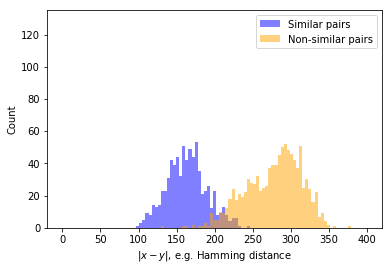

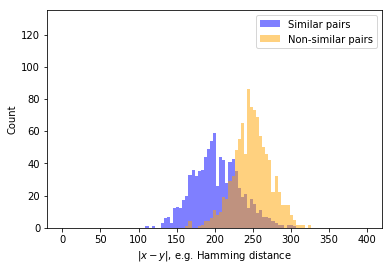

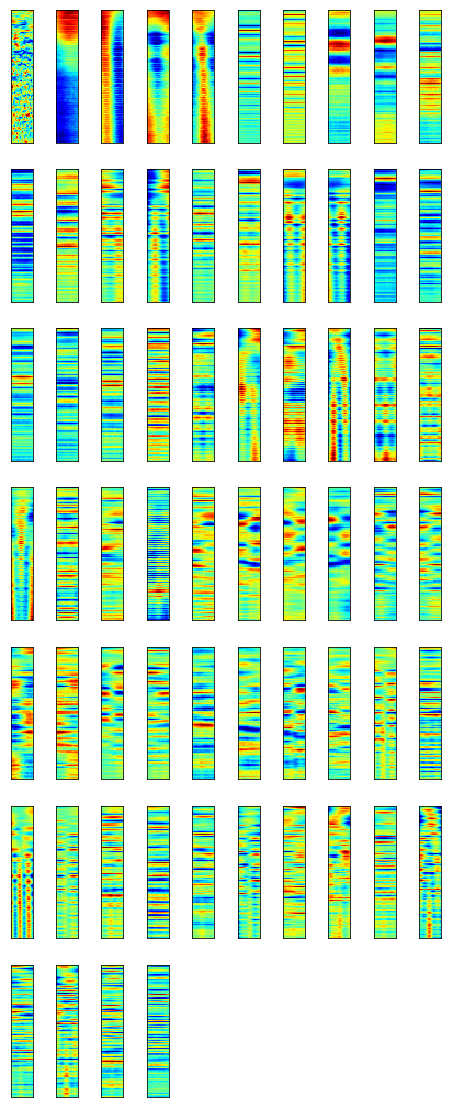

1898/1898 [==============================] - 0s 178us/step
2018-03-06 19:27:46,041 - root - DEBUG - [Iteration = 2] Training Loss = 24.20719273299116, Testing Loss = 35.90172079767643
2018-03-06 19:27:46,043 - root - DEBUG - Iteration 3 (current beta = 25)
Epoch 1/50
1736/1736 [==============================] - 0s 281us/step - loss: 24.3138
Epoch 2/50
1736/1736 [==============================] - 0s 252us/step - loss: 24.4734
Epoch 3/50
1736/1736 [==============================] - 0s 255us/step - loss: 24.2865
Epoch 4/50
1736/1736 [==============================] - 0s 262us/step - loss: 24.5698
Epoch 5/50
1736/1736 [==============================] - 0s 280us/step - loss: 24.1682
Epoch 6/50
1736/1736 [==============================] - 0s 277us/step - loss: 24.2838
Epoch 7/50
1736/1736 [==============================] - 0s 260us/step - loss: 24.2839
Epoch 8/50
1736/1736 [==============================] - 0s 274us/step - loss: 24.1853
Epoch 9/50
1736/1736 [==============================] -

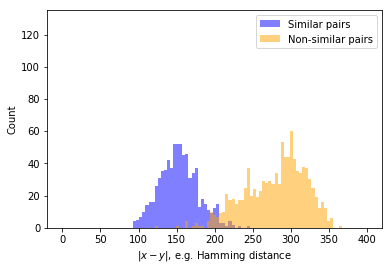

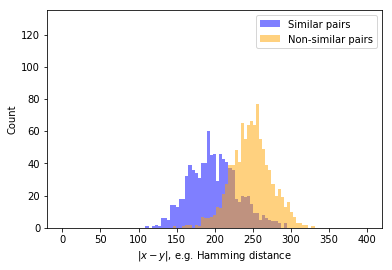

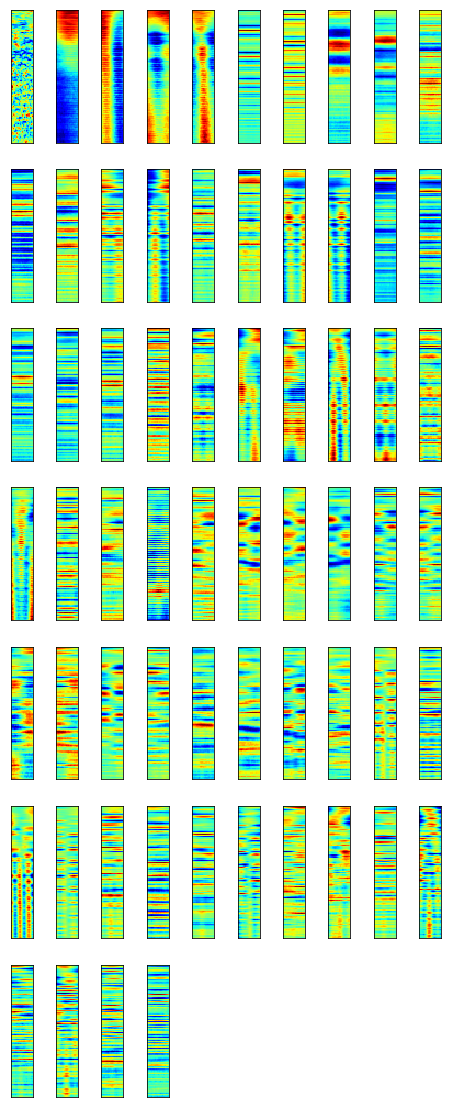

1898/1898 [==============================] - 0s 201us/step
2018-03-06 19:28:15,465 - root - DEBUG - [Iteration = 3] Training Loss = 23.028162459623978, Testing Loss = 35.933927952049906
2018-03-06 19:28:15,466 - root - DEBUG - Iteration 4 (current beta = 125)
Epoch 1/50
1736/1736 [==============================] - 0s 254us/step - loss: 22.9042
Epoch 2/50
1736/1736 [==============================] - 0s 243us/step - loss: 22.7524
Epoch 3/50
1736/1736 [==============================] - 0s 277us/step - loss: 22.7467
Epoch 4/50
1736/1736 [==============================] - 0s 269us/step - loss: 22.7526
Epoch 5/50
1736/1736 [==============================] - 0s 261us/step - loss: 22.8445
Epoch 6/50
1736/1736 [==============================] - 0s 285us/step - loss: 22.5871
Epoch 7/50
1736/1736 [==============================] - 0s 281us/step - loss: 23.0741
Epoch 8/50
1736/1736 [==============================] - 0s 274us/step - loss: 22.6870
Epoch 9/50
1736/1736 [==============================

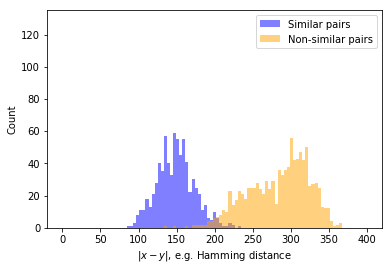

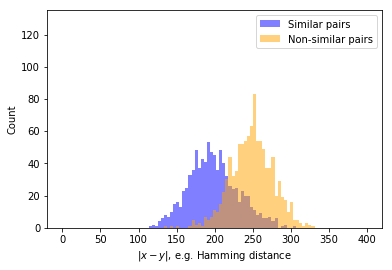

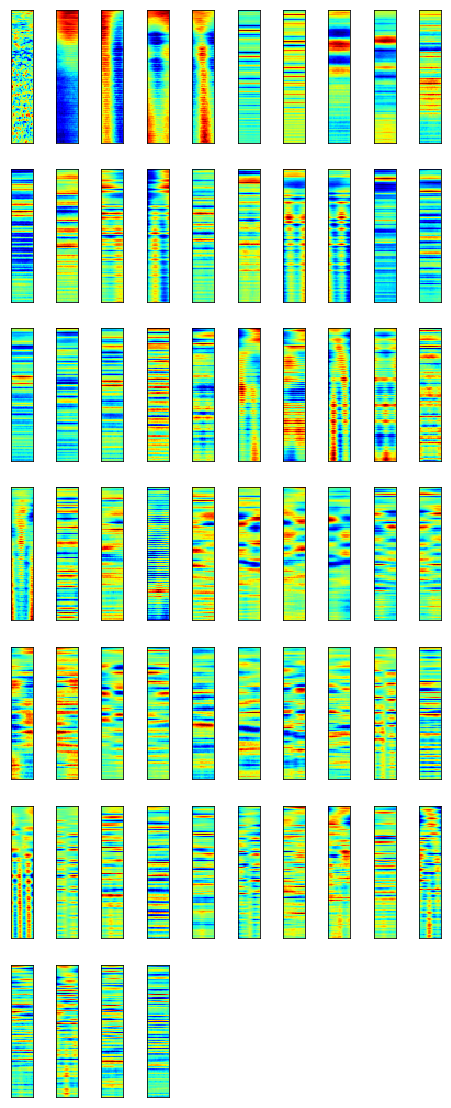

1898/1898 [==============================] - 0s 191us/step
2018-03-06 19:28:43,269 - root - DEBUG - [Iteration = 4] Training Loss = 21.850316759628086, Testing Loss = 35.64894221379207
2018-03-06 19:28:43,270 - root - DEBUG - Iteration 5 (current beta = 625)
Epoch 1/50
1736/1736 [==============================] - 0s 280us/step - loss: 21.9877
Epoch 2/50
1736/1736 [==============================] - 0s 273us/step - loss: 21.8065
Epoch 3/50
1736/1736 [==============================] - 0s 277us/step - loss: 21.6909
Epoch 4/50
1736/1736 [==============================] - 0s 269us/step - loss: 21.7507
Epoch 5/50
1736/1736 [==============================] - 0s 241us/step - loss: 21.8046
Epoch 6/50
1736/1736 [==============================] - 0s 255us/step - loss: 21.6768
Epoch 7/50
1736/1736 [==============================] - 0s 270us/step - loss: 21.6137
Epoch 8/50
1736/1736 [==============================] - 0s 279us/step - loss: 21.6438
Epoch 9/50
1736/1736 [==============================]

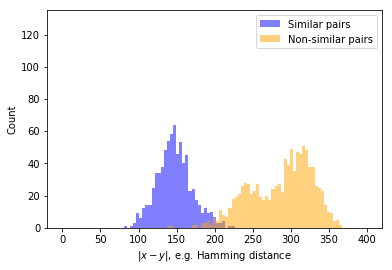

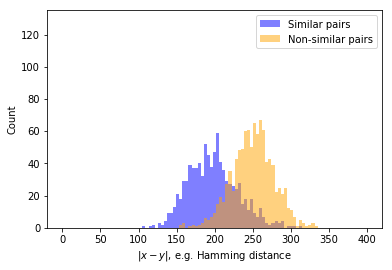

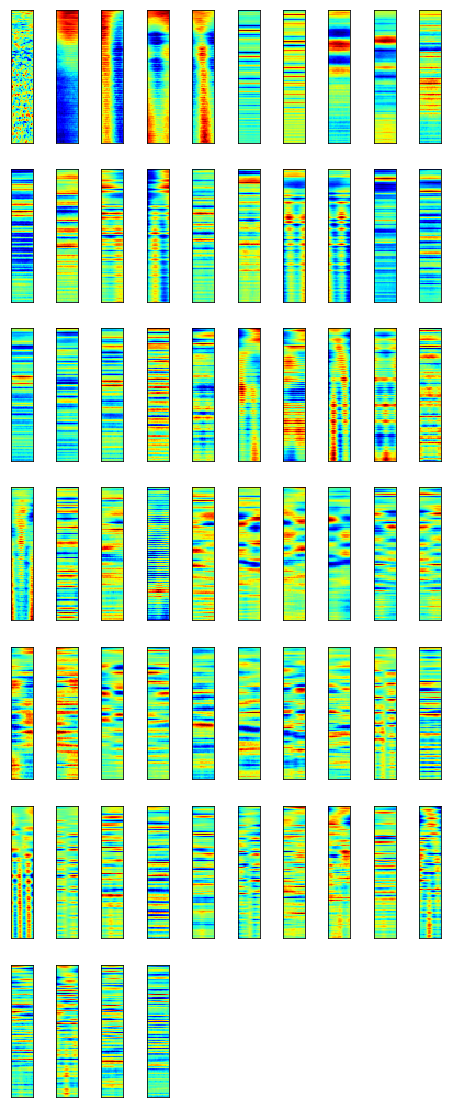

1898/1898 [==============================] - 0s 155us/step
2018-03-06 19:29:10,453 - root - DEBUG - [Iteration = 5] Training Loss = 20.990307067396454, Testing Loss = 35.06932732930802


In [33]:
for m in range(1, number_of_iterations+1):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor
    
    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)
    visualizeFilters()
    
    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

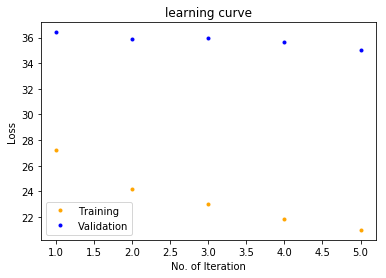

In [34]:
plt.figure()
plt.title("learning curve")
plt.plot(range(1,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(1,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

## Save Model

In [35]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(number_of_iterations)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

2018-03-06 19:29:10,647 - root - DEBUG - Save model to 2018-03-06[HashNet-without-dense-same-size][Iteration=5].h5


## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [36]:
representation_model = Model(image_a, encoded_a)

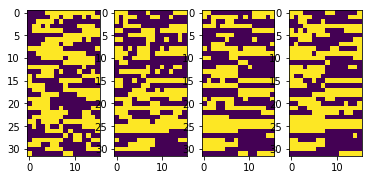

In [37]:
# Get sample output
# Reshaped to be (32,16) for visualization purposes.
pred_X1 = representation_model.predict(X1)
plt.subplot(1,4,1)
plt.imshow(pred_X1[:1].reshape(32,16) > 0)
plt.subplot(1,4,2)
plt.imshow(pred_X1[1:2].reshape(32,16) > 0)
plt.subplot(1,4,3)
plt.imshow(pred_X1[2:3].reshape(32,16) > 0)
plt.subplot(1,4,4)
plt.imshow(pred_X1[3:4].reshape(32,16) > 0)
plt.show()

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

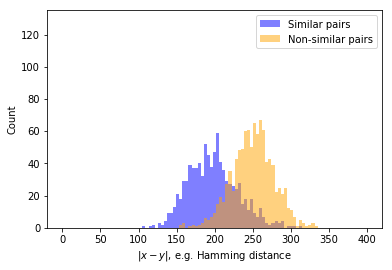

In [38]:
representation_model = Model(image_a, encoded_a)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Appendix: Architecture Details

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 8, 1)     175360      image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 512)          0           sequential_1[1][0]               
__________

In [40]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 12, 1)         154880    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 8, 1)          20480     
Total params: 175,360
Trainable params: 175,360
Non-trainable params: 0
_________________________________________________________________
